## Bibliotecas

In [1]:
!pip install rasterio geojson rasterstats owslib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.7 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from owslib.wcs import WebCoverageService
import requests
import geojson
import rasterio
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from rasterstats import zonal_stats
from io import BytesIO
from shapely.geometry import box
from matplotlib.colors import ListedColormap, BoundaryNorm


## Importando camada vetorial

In [3]:
# Parâmetros para conectar com a camada vetorial
mun_url = "https://info.dengue.mat.br/geoserver/wfs"

params_AML = dict(
    service="WFS",
    version="2.0.0",
    request="GetFeature",
    typeName="AP_subdistritos_CD2022", # usando camada de subdistritos, pois municípios na Amazônia são gigantes
    outputFormat="json",
)

# Fazendo o request
r_AML = requests.get(mun_url, params=params_AML)

# Baixando e carregando a camada
municipios = gpd.GeoDataFrame.from_features(geojson.loads(r_AML.content), crs="EPSG:4674")


In [4]:
municipios.head()

,geometry,id,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,CD_SUBDIST,NM_SUBDIST,CD_RGINT,NM_RGINT,CD_RGI,NM_RGI,CD_CONCURB,NM_CONCURB,SIGLA
0,"POLYGON ((-52.00182 0.93616, -52.00186 0.93637...",1,1,Norte,16,Amapá,1600055,Serra do Navio,160005505,Serra do Navio,16000550500,None,1602,Oiapoque - Porto Grande,160004,Porto Grande,None,None,AP
1,"POLYGON ((-52.01806 0.88724, -52.01771 0.8863,...",2,1,Norte,16,Amapá,1600055,Serra do Navio,160005510,Cachaço,16000551000,None,1602,Oiapoque - Porto Grande,160004,Porto Grande,None,None,AP
2,"POLYGON ((-50.45011 2.10924, -50.44715 2.10917...",3,1,Norte,16,Amapá,1600105,Amapá,160010505,Amapá,16001050500,None,1602,Oiapoque - Porto Grande,160003,Oiapoque,None,None,AP
3,"POLYGON ((-50.5088 2.18518, -50.5069 2.18443, ...",4,1,Norte,16,Amapá,1600105,Amapá,160010505,Amapá,16001050500,None,1602,Oiapoque - Porto Grande,160003,Oiapoque,None,None,AP
4,"POLYGON ((-50.77464 1.83875, -50.7747 1.8383, ...",5,1,Norte,16,Amapá,1600105,Amapá,160010505,Amapá,16001050500,None,1602,Oiapoque - Porto Grande,160003,Oiapoque,None,None,AP


In [5]:
# Filtrar para o município de estudo
municipio_estudo = "Oiapoque"

municipio_bbox = municipios[municipios['NM_DIST'].str.contains(municipio_estudo, case=False)]

# Obter os limites (bounding box) do Oiapoque/AP
xmin, ymin, xmax, ymax = municipio_bbox.total_bounds
xmin, ymin, xmax, ymax


(np.float64(-51.855426),
 np.float64(3.17639),
 np.float64(-51.356847),
 np.float64(4.394141))

In [6]:
municipio_bbox.total_bounds

array([-51.855426,   3.17639 , -51.356847,   4.394141])

## Importando rasters de 2008 e 2022

### 1 - Descobrindo o tamanho em pixels do raster

In [7]:
import requests
import xml.etree.ElementTree as ET

# Parâmetros para o WCS e a cobertura
wcs_url = "https://info.dengue.mat.br/geoserver/wcs"
wcs_version = "1.0.0"
coverage_id = "brasil_uso_cob:mapbiomas_brasil_coverage_2008"

# Monta a URL para o DescribeCoverage (sem espaços, com os parâmetros necessários)
describe_url = (f"{wcs_url}?service=WCS&version={wcs_version}"
                f"&request=DescribeCoverage&coverage={coverage_id}")

r_describe = requests.get(describe_url)
if r_describe.status_code != 200:
    raise Exception("Erro no DescribeCoverage: " + str(r_describe.status_code))

# Parseia o XML da resposta
root = ET.fromstring(r_describe.content)
# Definir os namespaces – pode ser necessário ajustar se o XML usar outros valores
ns = {
    "wcs": "http://www.opengis.net/wcs",
    "gml": "http://www.opengis.net/gml"
}

# Procura o elemento GridEnvelope na resposta (normalmente dentro de CoverageDescription)
grid_env = root.find(".//gml:GridEnvelope", ns)
if grid_env is None:
    raise Exception("Nenhum elemento <gml:GridEnvelope> encontrado no DescribeCoverage.")

low_elem = grid_env.find("gml:low", ns)
high_elem = grid_env.find("gml:high", ns)
if low_elem is None or high_elem is None:
    raise Exception("Elementos <gml:low> ou <gml:high> não foram encontrados no GridEnvelope.")

# Os valores geralmente vêm como uma string com dois números separados por espaço
low_vals = list(map(int, low_elem.text.split()))
high_vals = list(map(int, high_elem.text.split()))
native_width = high_vals[0] - low_vals[0] + 1
native_height = high_vals[1] - low_vals[1] + 1
print("Dimensões nativas extraídas (width x height):", native_width, "x", native_height)


Dimensões nativas extraídas (width x height): 155241 x 158828


### 2 - Calculando o tamanho em pixels do recorte que faremos (para manter a mesma resolucão)

In [8]:
# Metadados do raster original (exemplo)
orig_bbox = (-73.98318216, -16.66197917, -43.39929216, 5.26958083)  # (xmin, ymin, xmax, ymax)
native_width = 155241   # largura original em pixels
native_height = 158828  # altura original em pixels

# Calcular resolução em x e y
res_x = (orig_bbox[2] - orig_bbox[0]) / native_width
res_y = (orig_bbox[3] - orig_bbox[1]) / native_height
print("Resolução em x:", res_x)
print("Resolução em y:", res_y)

# Definir a bbox do recorte (por exemplo, uma região de interesse)
crop_bbox = (float(xmin), float(ymin), float(xmax), float(ymax))  # convertendo de np.float para float simples
# crop_bbox = (-52.7506, 3.6626, -51.7776, 4.0039)

# Calcular dimensões do recorte em pixels
crop_width_pixels = int(round((crop_bbox[2] - crop_bbox[0]) / res_x))
crop_height_pixels = int(round((crop_bbox[3] - crop_bbox[1]) / res_y))

print("Dimensões nativas do recorte (pixels): {} x {}".format(crop_width_pixels, crop_height_pixels))


Resolução em x: 0.00019700910197692617
Resolução em y: 0.000138083713199184
Dimensões nativas do recorte (pixels): 2531 x 8819


In [9]:
crop_bbox

(-51.855426, 3.17639, -51.356847, 4.394141)

In [10]:
coverage_id = "amazonia_terraclass:terraclass_AMZ.2008.M"
crs = "EPSG:4674"
output_format = "image/geotiff"

wcs = WebCoverageService(wcs_url, version=wcs_version, timeout=None)

# Executa a requisição para obter a cobertura
response_2008 = wcs.getCoverage(
    identifier=coverage_id,
    format=output_format,
    crs=crs,
    bbox=crop_bbox,#(-51.855426, 3.17639, -51.356847, 4.394141), # não consigo usar o objeto crop_bbox, por isso o hardcoding
    # bbox=(-52.7506, 3.6626, -51.7776, 4.0039), # zoom na área urbana do Oiapoque
    width=crop_width_pixels,
    height=crop_height_pixels,
    timeout=None
)

output_file = "terraclass_2008.tif"
# output_file = "/content/drive/MyDrive/Rasters/terraclass_2008.tif"
with open(output_file, "wb") as f:
    f.write(response_2008.read())


In [11]:
coverage_id = "amazonia_terraclass:terraclass_AMZ.2022.M"

# Executa a requisição para obter a cobertura
response_2022 = wcs.getCoverage(
    identifier=coverage_id,
    format=output_format,
    crs=crs,
    bbox=(-51.855426, 3.17639, -51.356847, 4.394141), # não consigo usar o objeto crop_bbox, por isso o hardcoding
    # bbox=(-52.7506, 3.6626, -51.7776, 4.0039), # zoom na área urbana do Oiapoque
    width=crop_width_pixels,
    height=crop_height_pixels,
    timeout=None
)

output_file = "terraclass_2022.tif"
# output_file = "/content/drive/MyDrive/Rasters/terraclass_2022.tif"
with open(output_file, "wb") as f:
    f.write(response_2022.read())


In [12]:
# Abre o raster de 2008
src_2008 = rasterio.open("terraclass_2008.tif")

data_2008 = src_2008.read(1) # Lê a banda 1 como array NumPy
profile_2008 = src_2008.profile # Metadados (dimensão, CRS, etc.)
nodata_2008 = src_2008.nodata
transform_2008 = src_2008.transform


In [13]:
# Abre o raster de 2022
src_2022 = rasterio.open("terraclass_2022.tif")

data_2022 = src_2022.read(1)
profile_2022 = src_2022.profile
nodata_2022 = src_2022.nodata
transform_2022 = src_2022.transform


In [14]:
# Se os rasters tiverem valor NoData, mascaramos esses pixels para que apareçam em branco
if nodata_2008 is not None:
    data_2008 = np.ma.masked_equal(data_2008, nodata_2008)
if nodata_2022 is not None:
    data_2022 = np.ma.masked_equal(data_2022, nodata_2022)


In [15]:
extent = [src_2008.bounds.left, src_2008.bounds.right, src_2008.bounds.bottom, src_2008.bounds.top]
extent


[-51.855426, -51.356847, 3.17639, 4.394141]

In [16]:
print(profile_2008)
print(profile_2022)


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2531, 'height': 8819, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4674"]]'), 'transform': Affine(0.0001969889371789804, 0.0, -51.855426,
       0.0, -0.0001380826624333825, 4.394141), 'blockxsize': 848, 'blockysize': 976, 'tiled': True, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2531, 'height': 8819, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORI

## Definindo paleta de cores de uso/cobertura da terra

In [17]:
# Definindo a paleta de cores conforme o QML
palette = {
    1:  ("#005500", "Vegetação natural florestal primária"),
    2:  ("#0fc80f", "Vegetação natural florestal secundária"),
    9:  ("#a8a800", "Silvicultura"),
    10: ("#e6a04b", "Pastagem arbustiva/arbórea"),
    11: ("#ffec87", "Pastagem herbácea"),
    12: ("#ff8828", "Cultura agrícola perene"),
    13: ("#996400", "Cultura agrícola semiperene"),
    16: ("#ad89cd", "Mineração"),
    17: ("#ffa8c0", "Urbanizada"),
    20: ("#e1e1e1", "Outros usos"),
    22: ("#ff0000", "Desflorestamento no ano"),
    23: ("#0000ff", "Corpo d'água"),
    25: ("#ffffff", "Não observado"),
    50: ("#ff00ff", "Não floresta"),
    52: ("#ffff00", "Cultura agrícola temporária"),
}


In [18]:
# Criar uma lista com as chaves ordenadas (classes existentes)
sorted_keys = sorted(palette.keys())
sorted_keys

[1, 2, 9, 10, 11, 12, 13, 16, 17, 20, 22, 23, 25, 50, 52]

In [19]:
# Lista de cores correspondente à ordem das classes
colors = [palette[k][0] for k in sorted_keys]
colors


['#005500',
 '#0fc80f',
 '#a8a800',
 '#e6a04b',
 '#ffec87',
 '#ff8828',
 '#996400',
 '#ad89cd',
 '#ffa8c0',
 '#e1e1e1',
 '#ff0000',
 '#0000ff',
 '#ffffff',
 '#ff00ff',
 '#ffff00']

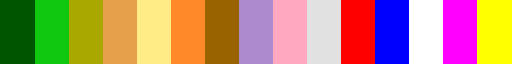

In [20]:
# Criando um colormap discreto
cmap = ListedColormap(colors)
cmap


In [21]:
# Definindo os limites de cada classe (usando k - 0.5 e k + 0.5)
boundaries = [k - 0.5 for k in sorted_keys] + [sorted_keys[-1] + 0.5]
boundaries


[0.5,
 1.5,
 8.5,
 9.5,
 10.5,
 11.5,
 12.5,
 15.5,
 16.5,
 19.5,
 21.5,
 22.5,
 24.5,
 49.5,
 51.5,
 52.5]

In [22]:
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
norm


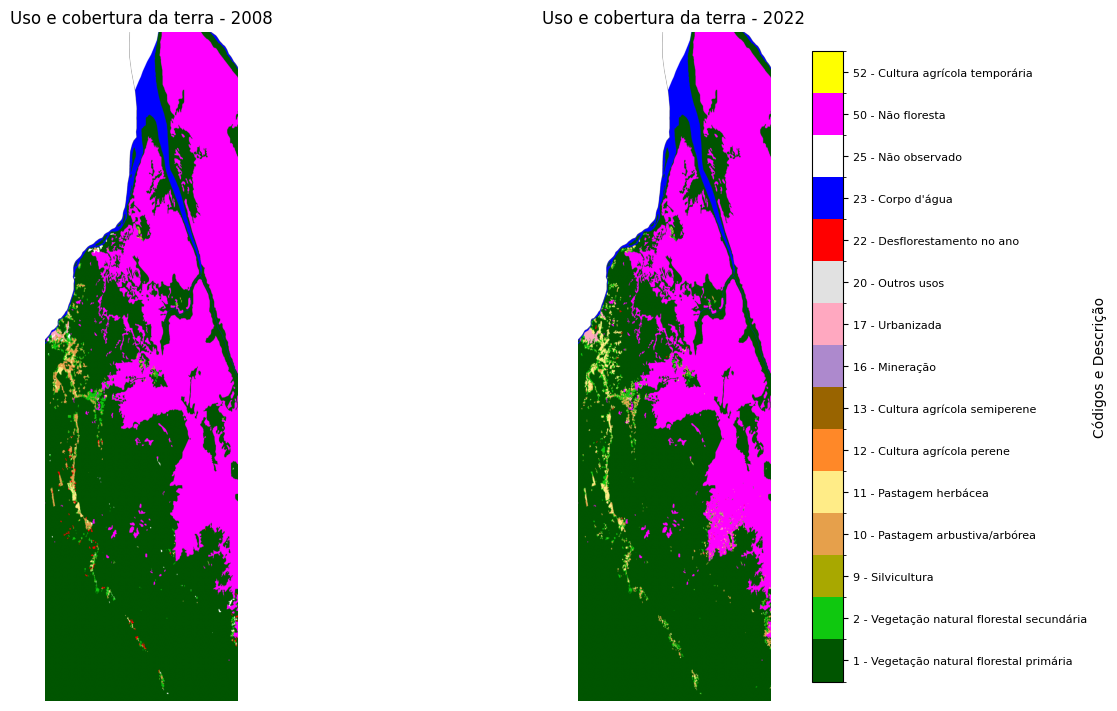

In [23]:
# Cria a figura com constrained_layout para melhor ajuste
fig, axs = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

# Plot do raster de 2008
im0 = axs[0].imshow(data_2008, cmap=cmap, norm=norm)
axs[0].set_title("Uso e cobertura da terra - 2008", fontsize=12)
axs[0].axis('off')

# Plot do raster de 2022
im1 = axs[1].imshow(data_2022, cmap=cmap, norm=norm)
axs[1].set_title("Uso e cobertura da terra - 2022", fontsize=12)
axs[1].axis('off')

# Calcula as posições centrais para os ticks da colorbar
ticks_center = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(len(sorted_keys))]

# Adiciona a barra de cores com os ticks centralizados
cbar = fig.colorbar(im1, ax=axs, fraction=0.03, pad=0.04, ticks=ticks_center)
cbar.ax.tick_params(labelsize=8)  # diminui o tamanho dos rótulos dos ticks
cbar.set_label("Códigos e Descrição", fontsize=10)

# Define os rótulos: número da classe e descrição na mesma linha
cbar.ax.set_yticklabels([f"{k} - {palette[k][1]}" for k in sorted_keys])

plt.show()


## Calculando a transição de qualquer pixel para urbano

In [24]:
# Identificando os pixels onde houve mudança para urbano: pixels que não eram 17 em 2008 e que são 17 em 2022
urban_change_bool = (data_2008 != 17) & (data_2022 == 17)
urban_change_bool


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=False)

In [25]:
# Converte o array booleano para binário (0 e 1): 1 = houve transição para urbano, 0 = não houve
urban_change_bin = urban_change_bool.astype(np.uint8)

# Atualiza o profile para refletir o novo tipo de dados e 1 banda
profile_2008.update(
    dtype=rasterio.uint8,
    count=1
)


In [26]:
# Salvando o raster resultante como um novo arquivo TIFF
output_path = "urban_change_2008_2022.tif"
with rasterio.open(output_path, 'w', **profile_2008) as dst:
    dst.write(urban_change_bin, 1)


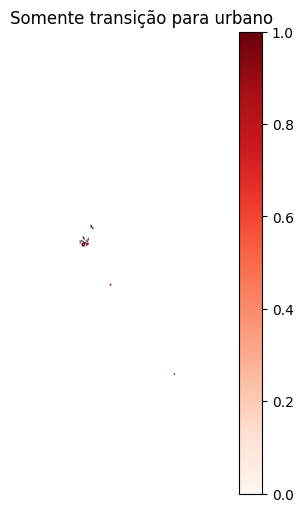

In [27]:
# Criando uma máscara para exibir somente os pixels que tiveram transição para urbano
urban_change_mask = np.ma.masked_where(urban_change_bin == 0, urban_change_bin)

# Visualizando apenas os pixels que mudaram para urbano
plt.figure(figsize=(8, 6))
plt.imshow(urban_change_mask, cmap='Reds', vmin=0, vmax=1)
plt.title("Somente transição para urbano")
plt.colorbar()
plt.axis('off')
plt.show()


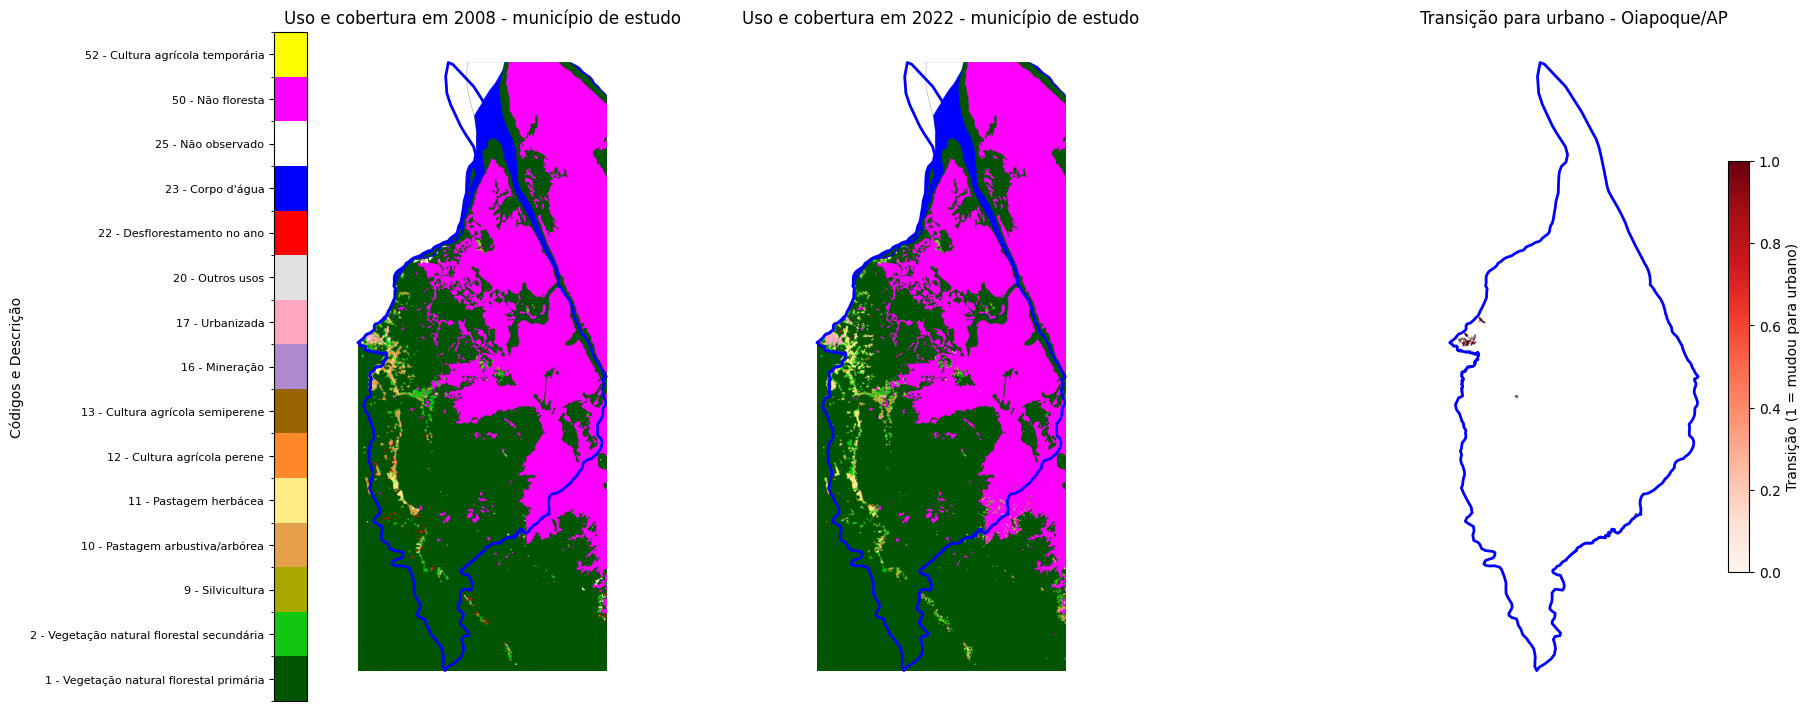

In [28]:
# Criando margens para melhorar visualização
margin_x = (xmax - xmin) * 0.05
margin_y = (ymax - ymin) * 0.05

# Figura com três subplots lado a lado
fig, axs = plt.subplots(1, 3, figsize=(18, 7), constrained_layout=True)

# Subplot 0: Raster de 2008 com zoom em município de estudo
im0 = axs[0].imshow(data_2008, cmap=cmap, norm=norm, extent=extent)
axs[0].set_title("Uso e cobertura em 2008 - município de estudo", fontsize=12)
municipio_bbox.boundary.plot(ax=axs[0], edgecolor='blue', linewidth=2)
axs[0].set_xlim(xmin - margin_x, xmax + margin_x)
axs[0].set_ylim(ymin - margin_y, ymax + margin_y)
axs[0].axis('off')

# Subplot 1: Raster de 2022 com zoom em município de estudo
im1 = axs[1].imshow(data_2022, cmap=cmap, norm=norm, extent=extent)
axs[1].set_title("Uso e cobertura em 2022 - município de estudo", fontsize=12)
municipio_bbox.boundary.plot(ax=axs[1], edgecolor='blue', linewidth=2)
axs[1].set_xlim(xmin - margin_x, xmax + margin_x)
axs[1].set_ylim(ymin - margin_y, ymax + margin_y)
axs[1].axis('off')

# Adiciona uma colorbar comum para os subplots de uso/cobertura (im0 e im1)
# Posicionada à esquerda da figura
cbar1 = fig.colorbar(im0, ax=axs[:2], orientation='vertical', fraction=0.046, pad=0.04, ticks=ticks_center, location='left')
cbar1.set_label("Códigos e Descrição", fontsize=10)
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.set_yticklabels([f"{k} - {palette[k][1]}" for k in sorted_keys])

# Subplot 2: Pixels que mudaram para urbano (urban_change_mask) com zoom em município de estudo
im2 = axs[2].imshow(urban_change_mask, cmap='Reds', vmin=0, vmax=1, extent=extent)
axs[2].set_title("Transição para urbano - Oiapoque/AP", fontsize=12)
municipio_bbox.boundary.plot(ax=axs[2], edgecolor='blue', linewidth=2)
axs[2].set_xlim(xmin - margin_x, xmax + margin_x)
axs[2].set_ylim(ymin - margin_y, ymax + margin_y)
axs[2].axis('off')

# Adicionar uma colorbar para o subplot de transição
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
cbar.set_label("Transição (1 = mudou para urbano)", fontsize=10)

plt.show()


## Extraindo estatísticas zonais

In [29]:
municipio_estudo = "Oiapoque"

mun_estudo = municipios[municipios['NM_DIST'].str.contains(municipio_estudo, case=False)]


In [30]:
zs_2008 = zonal_stats(mun_estudo, data_2008, affine=transform_2008, categorical=True, nodata=nodata_2008)
zs_2008


[{1: 6063380,
  2: 144616,
  10: 160058,
  11: 44881,
  16: 386,
  17: 12756,
  20: 1649,
  22: 16642,
  23: 333381,
  25: 56245,
  50: 3624171}]

In [31]:
zs_2022 = zonal_stats(mun_estudo, data_2022, affine=transform_2008, categorical=True, nodata=nodata_2008)
zs_2022


[{1: 5996889,
  2: 195882,
  10: 98057,
  11: 152124,
  17: 26388,
  20: 495,
  22: 4154,
  23: 333381,
  25: 40712,
  51: 3610083}]

In [ ]:
pd.DataFrame(zs_2022)

,1,2,10,11,17,20,22,23,25,51
0,5996889,195882,98057,152124,26388,495,4154,333381,40712,3610083
